In [2]:
import numpy as np
import arviz as az
# import pymc3 as pm
import pickle
import time
import matplotlib.pyplot as plt
from google.protobuf import text_format
from scipy.stats import multivariate_normal as mvn
from scipy.stats import skewnorm
from scipy.stats import norm
from scipy.interpolate import griddata
from pp_mix.interface import estimate_density_seq
from pp_mix.params_helper import make_default_strauss
import pp_mix.protos.py.params_pb2 as params_pb2


from pp_mix.state import extract_chain
from pp_mix.interface import ConditionalMCMC, estimate_density_seq, simulate_strauss2d
from pp_mix.utils import loadChains, to_numpy, to_proto
from pp_mix.protos.py.state_pb2 import MultivariateMixtureState, UnivariateMixtureState
from pp_mix.protos.py.params_pb2 import Params

# Simulation 1: contamination from DP

In [ ]:
from scipy.stats import dirichlet

true_mu = np.array([-3.5, 3, 0, 6])
true_sigma = np.array([0.8, 0.5, 0.4, 0.5])
w_t = np.array([0.25, 0.25, 0.3, 0.2])

alpha0 = 500
L = 10000
y_t = np.random.choice(len(w_t), size=L, replace=True, p=w_t)
locations = true_mu[y_t] + true_sigma[y_t] * np.random.normal(size=L)
weights = dirichlet.rvs(np.ones(L) * 500 / L)[0, :]
s = 0.25


def f0(x):
    out = np.zeros_like(x)
    for w, l in zip(weights, locations):
        out += w * norm.pdf(x, l, s)
    return out

In [ ]:
data = np.loadtxt("data/data_univ_miller_dunson.txt")

In [43]:
# estimate density using Strauss

strauss_chains = loadChains("data/perturb_strauss_chains.recordio", UnivariateMixtureState)
xgrid = np.linspace(-6, 8, 500)
f_eval = f0(xgrid)

dens_strauss = estimate_density_seq(strauss_chains, xgrid)

# load estimated densities from DPM (see R script)
bnpmix_estimate = np.loadtxt("data/data_univ_miller_dunson_dens_bnpmix.txt")

# plot
plt.plot(xgrid, np.mean(dens_strauss, axis=0), color="steelblue", label="strauss")
plt.plot(xgrid, f_eval, color="red", label="true")
plt.plot(np.linspace(-10, 10, 200), np.mean(bnpmix_estimate, axis=0), color="green", label="DPM")
plt.xlim(-6, 8)
plt.legend()
plt.show()

NameError: name 'f0' is not defined

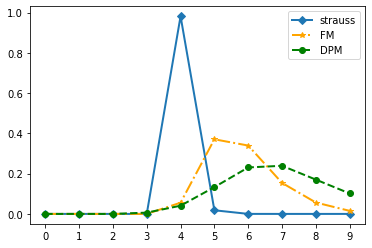

In [46]:
# plot number of clusters

k_chain_raf = np.loadtxt("data/data_univ_miller_dunson_K_raf.txt")
k_chain_bnp = np.loadtxt("data/data_univ_miller_dunson_K_bnpmix.txt")
k_chain_strauss = np.array([max(x.clus_alloc) + 1 for x in strauss_chains])

bars = np.arange(0, 10)
heights = np.array([np.sum(k_chain_strauss == i) for i in bars]) / len(k_chain_strauss)
plt.plot(bars, heights, 'D-', label="strauss", linewidth=2)

heights = np.array([np.sum(k_chain_raf == i) for i in bars]) / len(k_chain_raf)
plt.plot(bars, heights, '*-.', label="FM", linewidth=2, color="orange")

heights = np.array([np.sum(k_chain_bnp == i) for i in bars]) / len(k_chain_bnp)
plt.plot(bars, heights, 'o--', label="DPM", linewidth=2, color="green")

plt.xticks(bars)

plt.legend()
plt.savefig("images/k_chain_strauss_fm_dpm_1.pdf")

plt.show()

# Simulation 2: t and skewnorm

In [6]:
from scipy.stats import t, skewnorm

def generate_data(ndata, dim):
    if dim == 1:
        data = np.concatenate([
            [t.rvs(5, loc=-5) for _ in range(int(ndata/2))],
            [skewnorm.rvs(2, loc=5) for _ in range(int(ndata/2))]])
    else:
        data = np.vstack([
            t.rvs(5, loc=-5, size=(int(ndata/2), dim)),
            skewnorm.rvs(2, loc=5, size=(int(ndata/2), dim))])
        
    return data

In [7]:
for dim in [5]:
    data = generate_data(500, dim)
    np.savetxt("data/sim_t_skew_dim{0}.txt".format(dim), data)
    
    strauss_params = make_default_strauss(data)
    strauss_params.fixed_params=True
    if dim == 1:
            prec_params = params_pb2.GammaParams(alpha=1.0, beta=1.0)
    else:
        prec_params = params_pb2.WishartParams(
            nu=dim+1,identity=True, sigma=3, dim=dim)
    gamma_jump_params = params_pb2.GammaParams(alpha=1, beta=1)
        
    strauss_sampler = ConditionalMCMC(
            pp_params=strauss_params,
            prec_params=prec_params,
            jump_params=gamma_jump_params)
    
    strauss_sampler.run(50000, 50000, 5, data)
    strauss_sampler.serialize_chains("data/sim_t_skew_dim{0}_chains.recordio".format(dim))

Burnin, iter # 200  /  50000
Burnin, iter # 400  /  50000
Burnin, iter # 600  /  50000
Burnin, iter # 800  /  50000
Burnin, iter # 1000  /  50000
Burnin, iter # 1200  /  50000
Burnin, iter # 1400  /  50000
Burnin, iter # 1600  /  50000
Burnin, iter # 1800  /  50000
Burnin, iter # 2000  /  50000
Burnin, iter # 2200  /  50000
Burnin, iter # 2400  /  50000
Burnin, iter # 2600  /  50000
Burnin, iter # 2800  /  50000
Burnin, iter # 3000  /  50000
Burnin, iter # 3200  /  50000
Burnin, iter # 3400  /  50000
Burnin, iter # 3600  /  50000
Burnin, iter # 3800  /  50000
Burnin, iter # 4000  /  50000
Burnin, iter # 4200  /  50000
Burnin, iter # 4400  /  50000
Burnin, iter # 4600  /  50000
Burnin, iter # 4800  /  50000
Burnin, iter # 5000  /  50000
Burnin, iter # 5200  /  50000
Burnin, iter # 5400  /  50000
Burnin, iter # 5600  /  50000
Burnin, iter # 5800  /  50000
Burnin, iter # 6000  /  50000
Burnin, iter # 6200  /  50000
Burnin, iter # 6400  /  50000
Burnin, iter # 6600  /  50000
Burnin, iter #

Running, iter # 3800  /  50000
Running, iter # 4000  /  50000
Running, iter # 4200  /  50000
Running, iter # 4400  /  50000
Running, iter # 4600  /  50000
Running, iter # 4800  /  50000
Running, iter # 5000  /  50000
Running, iter # 5200  /  50000
Running, iter # 5400  /  50000
Running, iter # 5600  /  50000
Running, iter # 5800  /  50000
Running, iter # 6000  /  50000
Running, iter # 6200  /  50000
Running, iter # 6400  /  50000
Running, iter # 6600  /  50000
Running, iter # 6800  /  50000
Running, iter # 7000  /  50000
Running, iter # 7200  /  50000
Running, iter # 7400  /  50000
Running, iter # 7600  /  50000
Running, iter # 7800  /  50000
Running, iter # 8000  /  50000
Running, iter # 8200  /  50000
Running, iter # 8400  /  50000
Running, iter # 8600  /  50000
Running, iter # 8800  /  50000
Running, iter # 9000  /  50000
Running, iter # 9200  /  50000
Running, iter # 9400  /  50000
Running, iter # 9600  /  50000
Running, iter # 9800  /  50000
Running, iter # 10000  /  50000
Running

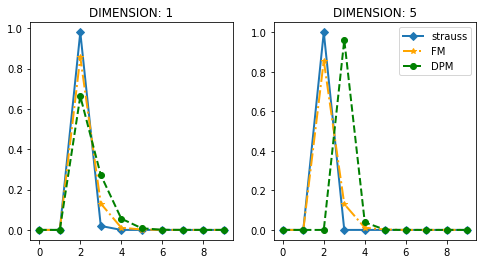

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

bars = np.arange(0, 10)
for i, dim in enumerate([1, 5]):
    objType = UnivariateMixtureState if dim == 1 else MultivariateMixtureState
    strauss_chains = loadChains("data/sim_t_skew_dim{0}_chains.recordio".format(dim), objType)
    k_chain_strauss = np.array([max(x.clus_alloc) + 1 for x in strauss_chains])
    heights = np.array([np.sum(k_chain_strauss == i) for i in bars]) / len(k_chain_strauss)
    axes[i].plot(bars, heights, 'D-', label="strauss", linewidth=2)
    
    k_chain_raf = np.loadtxt("data/sim_t_skew_dim{0}_Kraf.txt".format(dim))
    heights = np.array([np.sum(k_chain_raf == i) for i in bars]) / len(k_chain_raf)
    axes[i].plot(bars, heights, '*-.', label="FM", linewidth=2, color="orange")
    
    k_chain_bnp = np.loadtxt("data/sim_t_skew_dim{0}_Kbnpmix_s1.txt".format(dim))
    heights = np.array([np.sum(k_chain_bnp == i) for i in bars]) / len(k_chain_bnp)
    axes[i].plot(bars, heights, 'o--', label="DPM", linewidth=2, color="green")
    
#     k_chain_bnp = np.loadtxt("data/sim_t_skew_dim{0}_Kbnpmix_s5.txt".format(dim))
#     heights = np.array([np.sum(k_chain_bnp == i) for i in bars]) / len(k_chain_bnp)
#     axes[i].plot(bars, heights, 'o--', label="DPM, s=5", linewidth=2, color="y")
    
    axes[i].set_title("DIMENSION: {0}".format(dim))

plt.legend()
plt.savefig("images/t_skewnorm_k.pdf")
plt.show()

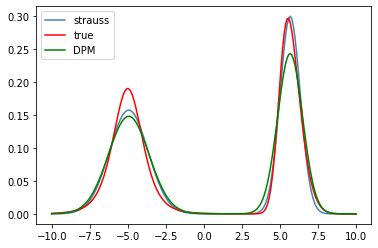

In [36]:
# Estimate density in 1D

xgrid = np.linspace(-10, 10, 200)
# estimate density using Strauss

strauss_chains = loadChains("data/sim_t_skew_dim1_chains.recordio", UnivariateMixtureState)
dens_strauss = estimate_density_seq(strauss_chains, xgrid)

# load estimated densities from DPM (see R script)
bnpmix_estimate = np.loadtxt("data/univ_t_skewnorm_dens_bnpmix.txt")

# True density
true_f = 0.5 * t.pdf(xgrid, 5, loc=-5) + 0.5 * skewnorm.pdf(xgrid, 2, loc=5)

# plot
plt.plot(xgrid, np.mean(dens_strauss, axis=0), color="steelblue", label="strauss")
plt.plot(xgrid, true_f, color="red", label="true")
plt.plot(xgrid, bnpmix_estimate, color="green", label="DPM")

# plt.xlim(-6, 8)
plt.legend()
plt.show()